In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
%run Pre.py

# Preparation

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
label_train = train['price_doc']
train_f = train.drop(['timestamp','id','price_doc'],axis=1)
test_f = test.drop(['id','timestamp'],axis=1)

In [4]:
features=list(train_f.columns)
for each in features:
    if train_f[each].dtype == 'object':
        train_f[each] = pd.factorize(train_f[each], sort=True)[0]
        test_f[each]=pd.factorize(test[each], sort=True)[0]

In [78]:
# Macro Data Preparation
macro = pd.read_csv('macro.csv')
# Clean Macro Data
var_macro = list(macro.columns)
for i in range(macro.shape[0]):
    for j in range(macro.shape[1]):
        try:
            macro.ix[i,j] = macro.ix[i,j].replace(',','')
            macro.ix[i,j] = macro.ix[i,j].replace('#!',None)
        except Exception:
            pass

In [80]:
var_macro.remove('timestamp')

In [82]:
for each in var_macro:
    macro[each] = macro[each].replace('#!',None)
    macro[each] = list(np.array(macro[each]).astype(np.float))

In [83]:
macro.to_csv('macro_clean.csv')

In [6]:
# Re-split data
from sklearn.model_selection import train_test_split
training,testing = train_test_split(train,test_size=0.2,random_state=42)
del training['id']
del testing['id']
var_train = list(training.columns)
var_train.remove('price_doc')
var_train.remove('timestamp')
training_fe = training[var_train]
training_la = training['price_doc']
testing_fe = testing[var_train]

In [8]:
# Re-do this 
for each in features:
    if training_fe[each].dtype == 'object':
        training_fe[each] = pd.factorize(training_fe[each], sort=True)[0]
        testing_fe[each]=pd.factorize(testing_fe[each], sort=True)[0]

# Base Model No FE

In [9]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
# For Training
dtraining = xgb.DMatrix(training_fe,training_la)
dtesting = xgb.DMatrix(testing_fe)
# For Final Model Predicting
dtrain = xgb.DMatrix(train_f, label_train)
dtest = xgb.DMatrix(test_f)

In [98]:
xgb_cvalid = xgb.cv(xgb_params, dtraining, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()

[0]	train-rmse:8.24514e+06	test-rmse:8.25172e+06
[50]	train-rmse:2.51348e+06	test-rmse:2.94697e+06
[100]	train-rmse:2.1698e+06	test-rmse:2.76154e+06
[150]	train-rmse:2.03886e+06	test-rmse:2.72204e+06
[200]	train-rmse:1.94877e+06	test-rmse:2.70442e+06
[250]	train-rmse:1.86937e+06	test-rmse:2.69245e+06
[300]	train-rmse:1.80605e+06	test-rmse:2.68742e+06
[350]	train-rmse:1.7451e+06	test-rmse:2.68202e+06


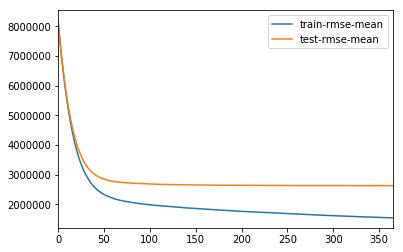

In [64]:
import matplotlib.pyplot as plt
plt.show()

In [76]:
def get_feature_importance(model):
    Importance = model.get_fscore()
    Importance = list(Importance.items())
    Feature= []
    Score = []
    for each in Importance:
        Feature.append(each[0])
        Score.append(each[1])
    df = pd.DataFrame({'Feature':Feature,'Score':Score}).sort_values(by=['Score'],ascending=[0])
    return df.iloc[0:50,]    

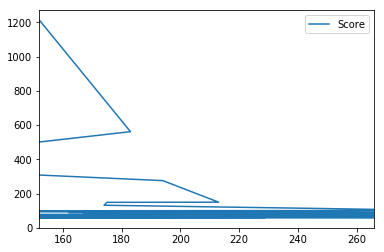

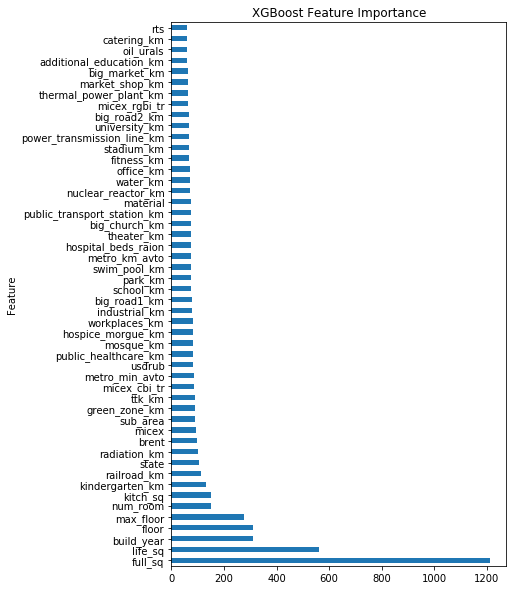

In [125]:
FImportance = get_feature_importance(model)
plt.figure()
FImportance.plot()
FImportance.plot(kind='barh', x='Feature', y='Score', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.show()

In [99]:
from sklearn.metrics import mean_squared_error as mse

In [10]:
## Train Splitted Dataset
num_boost_rounds = 1000#len(xgb_cvalid)
model = xgb.train(dict(xgb_params, silent=0), dtraining, num_boost_round= num_boost_rounds)
prediction = model.predict(dtesting)
Accuracy = mse(testing['price_doc'],prediction)

NameError: name 'mse' is not defined

In [102]:
print(str(Accuracy**0.5))

2480828.55793


In [11]:
from sklearn.metrics import mean_squared_error as mse
Accuracy = mse(testing['price_doc'],prediction)

In [12]:
print(str(Accuracy**0.5))

2494217.27067


In [138]:
Prediction = model.predict(dtest)
test_id = test['id']
submission = pd.DataFrame({'id':test_id,'price_doc':Prediction})
submission.to_csv('Submission_xgb1.csv')

# Choose Features in Macro and Combine

In [18]:
macro = pd.read_csv('macro_clean.csv')
#macro=macro.fillna(-1)

In [19]:
## Macro Economy Maybe able to influence the price of house per square meter.
merged_training = training.merge(macro,how='left',on='timestamp')
merged_testing = testing.merge(macro,how='left',on='timestamp')

In [20]:
col = list(macro.columns)
col.remove('timestamp')

In [21]:
#list(np.array(macro[each]).astype(np.float))
train_sqrtprice = list(np.array(merged_training['price_doc']/merged_training['full_sq']).astype(np.float64))
test_sqrtprice = list(np.array(merged_testing['price_doc']/merged_testing['full_sq']).astype(np.float64))

In [22]:
## Gonna Use it later
Average_price = np.mean(train['price_doc'])/np.mean(train['full_sq'])

In [23]:
merged_training['sqrt_price'] = train_sqrtprice
merged_testing['sqrt_price'] = test_sqrtprice

In [24]:
## Replace Infinity
merged_training = merged_training.replace(np.inf,Average_price)
merged_testing = merged_testing.replace(np.inf,Average_price)

In [25]:
merged_training_f = merged_training[col]
merged_testing_f = merged_testing[col]
merged_training_l = merged_training['sqrt_price']
merged_testing_l = merged_testing['sqrt_price']

In [27]:
## Fit a xgb on this case

In [26]:
dtraining_m = xgb.DMatrix(merged_training_f,merged_training_l)
dtesting_m = xgb.DMatrix(merged_testing_f)

In [31]:
print(Average_price)

131386.724732


In [32]:
Depth_Group = [3,5,7]
eta_group = [0.05,0.1,0.2]
def xgbcv_fit(depth,eta):
    xgb_params = {
    'eta': eta,
    'max_depth': depth,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
    }
    xgb_cvalid = xgb.cv(xgb_params, dtraining_m, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
    xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
    plt.show()
    print('Boosting_Round: '+str(len(xgb_cvalid)))

======================================== Validating Doing ========================================
[0]	train-rmse:346749	test-rmse:331631
[50]	train-rmse:315575	test-rmse:300887


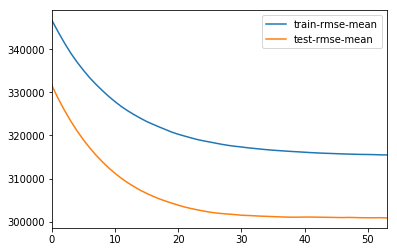

Boosting_Round: 54
======================================== Validating Doing ========================================
[0]	train-rmse:346595	test-rmse:331644
[50]	train-rmse:314287	test-rmse:303395


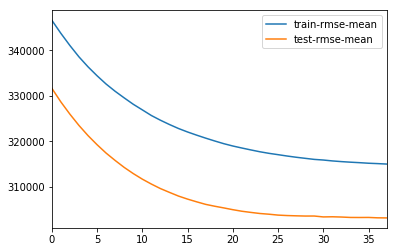

Boosting_Round: 38
======================================== Validating Doing ========================================
[0]	train-rmse:346506	test-rmse:331646
[50]	train-rmse:314033	test-rmse:304412


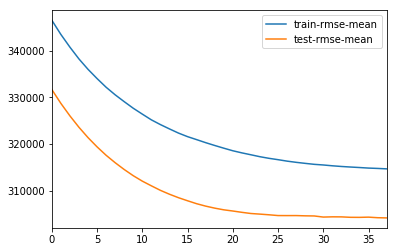

Boosting_Round: 38


In [35]:
## Tune Parameters ##
for each in Depth_Group:
    print('=='*20+' Validating Doing '+'=='*20)
    xgbcv_fit(each,0.05)

**Max Depth:3**

======================================== Validating Doing ========================================
[0]	train-rmse:346749	test-rmse:331631
[50]	train-rmse:315575	test-rmse:300887


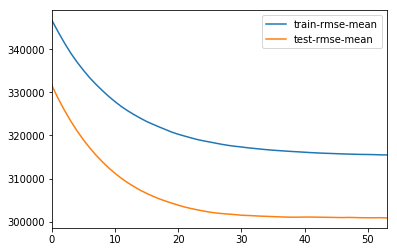

Boosting_Round: 54
======================================== Validating Doing ========================================
[0]	train-rmse:343915	test-rmse:328489


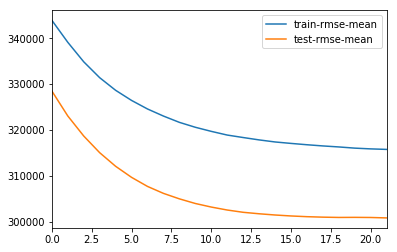

Boosting_Round: 22
======================================== Validating Doing ========================================
[0]	train-rmse:338635	test-rmse:322626


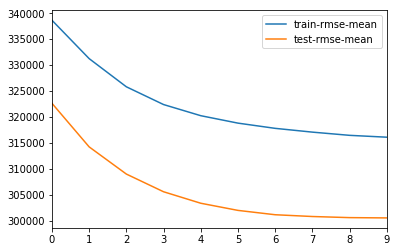

Boosting_Round: 10


In [36]:
for each in eta_group:
    print('=='*20+' Validating Doing '+'=='*20)
    xgbcv_fit(3,each)

**Seems 3+0.05 might be a good choice for this case.**

In [38]:
from sklearn.metrics import mean_squared_error as mse

In [56]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse'
    }
model = xgb.train(dict(xgb_params, silent=0), dtraining_m, num_boost_round=54)
prediction = model.predict(dtesting_m)
Accuracy = mse(merged_testing_l,prediction)

In [40]:
print(Accuracy)

51670.7029085


In [78]:
Feature_Importance = get_feature_importance(model)

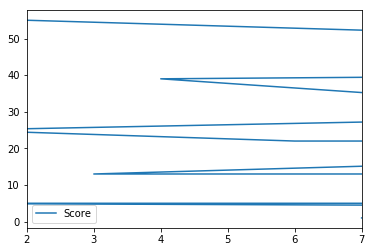

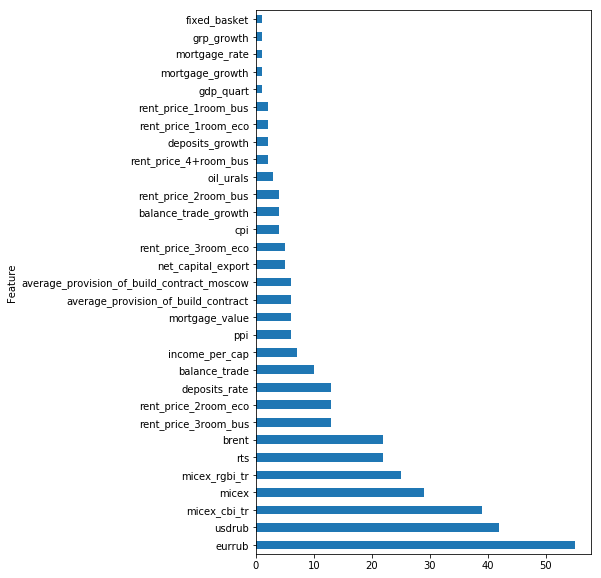

In [79]:
plt.figure()
Feature_Importance.plot()
Feature_Importance.plot(kind='barh', x='Feature', y='Score', legend=False, figsize=(6, 10))
plt.show()

In [83]:
Feature_Importance = Feature_Importance.reset_index(drop=True)
Top5F = list(Feature_Importance['Feature'][0:6])

In [87]:
Top5F.append('timestamp')
mac_sel = macro[Top5F]

In [89]:
## Do a xgboost regression with new features ##
train_f2= train.merge(mac_sel,how='left',on='timestamp').drop(['timestamp','id'],axis=1)
test_f2 = test.merge(mac_sel,how='left',on='timestamp').drop(['timestamp','id'],axis=1)

In [96]:
# Re-do this 
for each in features:
    if train_f2[each].dtype == 'object':
        train_f2[each] = pd.factorize(train_f2[each], sort=True)[0]
        test_f2[each]=pd.factorize(test_f2[each], sort=True)[0]

In [97]:
training_2,testing_2 = train_test_split(train_f2,test_size=0.2,random_state=42)
training_2_l= training_2['price_doc']
testing_2_l = testing_2['price_doc']
del training_2['price_doc']
del testing_2['price_doc']

In [98]:
dtraining2=xgb.DMatrix(training_2,training_2_l)
dtesting2=xgb.DMatrix(testing_2)

In [100]:
def xgbcv_fit(depth,eta):
    xgb_params = {
    'eta': eta,
    'max_depth': depth,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
    }
    xgb_cvalid = xgb.cv(xgb_params, dtraining2, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
    xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
    #plt.show()
    print('Boosting_Round: '+str(len(xgb_cvalid)))

In [102]:
Depth_pool = [5,6,7]
for each in Depth_pool:
    print('Round Starts')
    xgbcv_fit(each,0.05)

Round Starts
[0]	train-rmse:8.24515e+06	test-rmse:8.25169e+06
[50]	train-rmse:2.5175e+06	test-rmse:2.94282e+06
[100]	train-rmse:2.15576e+06	test-rmse:2.7532e+06
[150]	train-rmse:2.01431e+06	test-rmse:2.70971e+06
[200]	train-rmse:1.91231e+06	test-rmse:2.68871e+06
[250]	train-rmse:1.82679e+06	test-rmse:2.67715e+06
[300]	train-rmse:1.75113e+06	test-rmse:2.67051e+06
[350]	train-rmse:1.68665e+06	test-rmse:2.66563e+06
Boosting_Round: 362
Round Starts
[0]	train-rmse:8.24105e+06	test-rmse:8.24867e+06
[50]	train-rmse:2.31725e+06	test-rmse:2.8945e+06
[100]	train-rmse:1.94466e+06	test-rmse:2.72486e+06
[150]	train-rmse:1.78394e+06	test-rmse:2.68864e+06
[200]	train-rmse:1.66776e+06	test-rmse:2.67488e+06
[250]	train-rmse:1.57422e+06	test-rmse:2.66946e+06
[300]	train-rmse:1.49435e+06	test-rmse:2.66562e+06
[350]	train-rmse:1.41659e+06	test-rmse:2.66323e+06
Boosting_Round: 363
Round Starts
[0]	train-rmse:8.23858e+06	test-rmse:8.25017e+06
[50]	train-rmse:2.14076e+06	test-rmse:2.87458e+06
[100]	train-rms

In [104]:
eta_pool = [0.03,0.1]
for each in eta_pool:
    print('Round Starts')
    xgbcv_fit(6,each)

Round Starts
[0]	train-rmse:8.39187e+06	test-rmse:8.39631e+06
[50]	train-rmse:3.05853e+06	test-rmse:3.42618e+06
[100]	train-rmse:2.17886e+06	test-rmse:2.82557e+06
[150]	train-rmse:1.96966e+06	test-rmse:2.73958e+06
[200]	train-rmse:1.86256e+06	test-rmse:2.71261e+06
[250]	train-rmse:1.77893e+06	test-rmse:2.69695e+06
[300]	train-rmse:1.70306e+06	test-rmse:2.68515e+06
[350]	train-rmse:1.64018e+06	test-rmse:2.67884e+06
[400]	train-rmse:1.58381e+06	test-rmse:2.67477e+06
[450]	train-rmse:1.53345e+06	test-rmse:2.67088e+06
[500]	train-rmse:1.48681e+06	test-rmse:2.67073e+06
Boosting_Round: 492
Round Starts
[0]	train-rmse:7.86578e+06	test-rmse:7.88189e+06
[50]	train-rmse:1.96057e+06	test-rmse:2.76982e+06
[100]	train-rmse:1.69076e+06	test-rmse:2.72633e+06
[150]	train-rmse:1.52264e+06	test-rmse:2.71524e+06
[200]	train-rmse:1.38437e+06	test-rmse:2.7113e+06
Boosting_Round: 205


Good Combination: 6 and 0.05!

In [124]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
    }
model = xgb.train(dict(xgb_params, silent=0), dtraining2, num_boost_round= 363)

In [112]:
prediction = model.predict(dtesting2)
Accuracy = mse(testing_2_l,prediction)

In [114]:
print(str(Accuracy))

1302176.93552


Prepare for other submission

In [117]:
label = train_f2['price_doc']
del train_f2['price_doc']
dtrain2 = xgb.DMatrix(train_f2,label)
dtest2 = xgb.DMatrix(test_f2)

In [125]:
model = xgb.train(dict(xgb_params, silent=0), dtrain2, num_boost_round= 363)

In [128]:
Prediction = model.predict(dtest2)
test_id = test['id']
Submission4 = pd.DataFrame({'id':test_id,'price_doc':Prediction})

In [129]:
Submission4.to_csv('Submission4_2_EFeatures.csv',index=False)

In [122]:
ss = pd.read_csv('Submission_xgb1.csv')

# Model with SQRT Price as Label and Dealing SQRT Features

In [127]:
mse(ss['price_doc'],Prediction)

451121.926536805